In [1]:
import os
os.chdir("..")

In [2]:
from optimisation_helicoid import * 
from utils import *
import sklearn
from sklearn import *
from skimage import data
from skimage.filters import *

PATH:  /home/kevin/bll-piglets-helicoid


In [3]:
patient = "012-01"

/home/kevin/kenv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(443, 497, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4516
855
(302,)
(302, 10)


Text(0.5, 1.0, 'Yellow point with MAE 0.491 (Blood)')

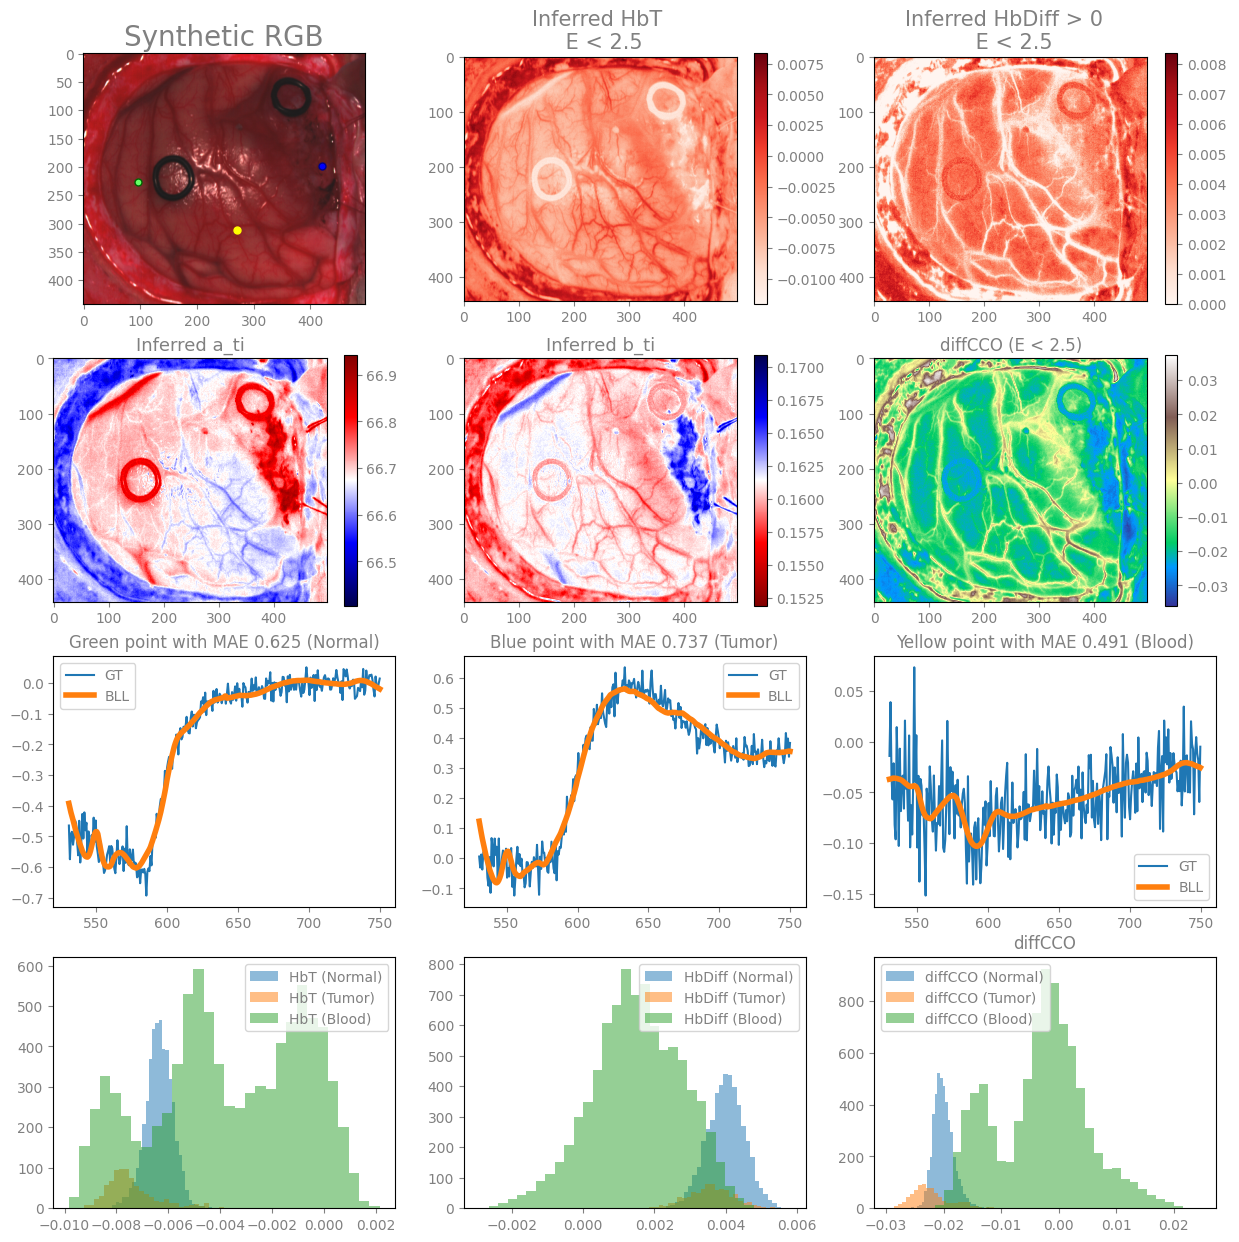

In [4]:
coarseness=1
hdr_path = path+"/{}/raw.hdr".format(patient)
img = open_image(hdr_path)
wavelength = np.array(img.metadata['wavelength']).astype(float)

rbg_path = path+"/{}/image.jpg".format(patient)
rbg = Image.open(rbg_path)

gt_path = path+"/{}/gtMap.hdr".format(patient)
gt = open_image(gt_path)
gt = gt.load()
print(gt.shape)

mpl.rc('image', cmap='terrain')

mpl.rcParams['text.color'] = 'grey'
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams['axes.labelcolor'] = 'grey'

tumor = gt==2
normal = gt==1
blood = gt==3
mask1 = np.ma.masked_where(tumor.astype(int) == 0, tumor.astype(int))
mask2 = np.ma.masked_where(normal.astype(int) == 0, normal.astype(int))
mask3 = np.ma.masked_where(blood.astype(int) == 0, blood.astype(int))

white_path = path+"/{}/whiteReference.hdr".format(patient)
white = open_image(white_path)
white = white.load()

dark_path = path+"/{}/darkReference.hdr".format(patient)

dark = open_image(dark_path)
dark = dark.load()
white_full = np.tile(white, (img.shape[0],1,1))
white_full_RGB = np.stack((white_full[:,:,int(img.metadata['default bands'][2])],white_full[:,:,int(img.metadata['default bands'][1])],white_full[:,:,int(img.metadata['default bands'][0])]), axis=2)
dark_full = np.tile(dark, (img.shape[0],1,1))

#img_normalized = np.array(img.load())
#img_normalized = (img.load() - dark_full) / (white_full - dark_full)
#img_normalized = img_normalized * 2
img_normalized = sfilter((img.load() - dark_full) / (white_full - dark_full)) + 0.1
#img_normalized = shiftw(img_normalized)
#img_normalized = np.array(img.load())
img_normalized[img_normalized <= 0] = 10**-2

wavelengths = np.array(img.metadata['wavelength']).astype(float)

molecules_cyto, x_cyto = read_molecules_cytochrome_cb(left_cut, right_cut, wavelengths)
molecules, x = read_molecules_creatis(left_cut, right_cut, x_waves=wavelengths)
y_c_oxy, y_c_red, y_b_oxy, y_b_red = molecules_cyto #, y_water, y_fat = molecules
y_hb_f, y_hbo2_f, y_coxa, y_creda, y_fat, y_water = molecules

M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                            np.asarray(y_hb_f),
                            np.asarray(y_coxa),
                            np.asarray(y_creda),
                            np.asarray(y_c_oxy),
                            np.asarray(y_c_red),
                            np.asarray(y_b_oxy),
                            np.asarray(y_b_red),
                            np.asarray(y_water),
                            np.asarray(y_fat))))


img_ref, reference_point, coefs, scattering_params, errors, t1 = load_helicoid_optimization_data(patient)
img_ref, reference_point, coefs, scattering_params, errors, t1 = img_ref.numpy(), reference_point.numpy(), coefs.numpy(), scattering_params.numpy(), errors.numpy(), t1.numpy() 
a_t1, b_t1 = t1[0], t1[1]
hbt_inferred = coefs[:,:,0] + coefs[:,:,1]
hbdiff_inferred = coefs[:,:,0] - coefs[:,:,1]
diffCCO_inferred = coefs[:,:,2] - coefs[:,:,3]
blood_scattering_inferred = scattering_params[:,:,0]
brain_scattering_inferred = scattering_params[:,:,1]
error_inferred = errors

img_RGB = np.stack((img_normalized[::coarseness,::coarseness,int(img.metadata['default bands'][2])],img_normalized[::coarseness,::coarseness,int(img.metadata['default bands'][1])],img_normalized[::coarseness,::coarseness,int(img.metadata['default bands'][0])]), axis=2)

error_tolerance = 2.5
(x_normal,y_normal) = np.where((np.squeeze(gt[::coarseness,::coarseness,:])==1) & (error_inferred < error_tolerance))
(x_tumor,y_tumor) = np.where((np.squeeze(gt[::coarseness,::coarseness,:])==2) & (error_inferred < error_tolerance))
(x_blood,y_blood) =  np.where((np.squeeze(gt[::coarseness,::coarseness,:])==3) & (error_inferred < error_tolerance))

fig, axs = plt.subplots(nrows=4, ncols=3,figsize=(15,15))
ax_RGB, ax_hbt, ax_cco, ax_bloodscatter, ax_brainscatter, ax_error, ax_greenpoint, ax_bluepoint, ax_yellowpoint, ax_bottom1, ax_bottom2, ax_bottom3 = axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1], axs[1,2], axs[2,0], axs[2,1], axs[2,2], axs[3,0], axs[3,1], axs[3,2]
ax_RGB.imshow(img_RGB)
ax_RGB.set_title("Synthetic RGB", fontsize=20)
#ax_RGB.imshow(mask1, cmap=cm.tab10)
#ax_RGB.imshow(mask2, cmap=cm.Dark2)
#ax_RGB.imshow(mask3, cmap=cm.get_cmap('spring_r'))

hbt_filtered = hbt_inferred
hbt_filtered = np.where(error_inferred > error_tolerance, np.min(hbt_inferred), hbt_filtered)
#hbt_filtered = np.where(hbt_filtered < 0.0, 0, hbt_filtered)
hbt_img = ax_hbt.imshow(hbt_filtered, cmap='Reds')
fig.colorbar(hbt_img, ax=ax_hbt)
#ax_hbt.set_title("Inferred HbT > 0 \n Fitting MAE < " + str(error_tolerance), fontsize=15)
ax_hbt.set_title("Inferred HbT \n E < " + str(error_tolerance), fontsize=15)

# CCO_inferred_filtered = np.where(error_inferred > error_tolerance, np.min(CCO_inferred), CCO_inferred)
# CCO_inferred_filtered = np.where(CCO_inferred_filtered < 0, 0, CCO_inferred_filtered)
# CCO_img = ax_cco.imshow(CCO_inferred_filtered)
# fig.colorbar(CCO_img, ax=ax_cco)
# ax_cco.set_title("CCO > 0(MAE < " + str(error_tolerance) +")")
hbdiff_filtered = hbdiff_inferred
hbdiff_filtered = np.where(error_inferred > error_tolerance, np.min(hbdiff_inferred), hbdiff_filtered)
hbdiff_filtered = np.where(hbdiff_filtered < 0.0, 0, hbdiff_filtered)
hbdiff_img = ax_cco.imshow(hbdiff_filtered, cmap='Reds')
fig.colorbar(hbdiff_img, ax=ax_cco)
#ax_hbt.set_title("Inferred HbT > 0 \n Fitting MAE < " + str(error_tolerance), fontsize=15)
ax_cco.set_title("Inferred HbDiff > 0  \n E < " + str(error_tolerance), fontsize=15)

#hbt_filtered_neg = hbdiff_inferred
#hbt_filtered_neg = np.where(hbt_filtered_neg > 0.0, 0, hbt_filtered_neg)
# hbt_filtered_neg = np.where(error_inferred > error_tolerance, 0, hbt_filtered_neg)
# hbt_neg_img = ax_cco.imshow(hbt_filtered_neg)
# fig.colorbar(hbt_neg_img, ax=ax_cco)
# #ax_cco.set_title("Inferred HbDiff > 0\n Fitting MAE < " + str(error_tolerance), fontsize=15)
# ax_cco.set_title("Inferred  \n Fitting MAE < " + str(error_tolerance), fontsize=15)

blood_scattering_inferred_filtered = blood_scattering_inferred
#blood_scattering_inferred_filtered = np.where(blood_scattering_inferred > 0.0, 0, blood_scattering_inferred)
#blood_scattering_inferred_filtered = np.where(error_inferred > error_tolerance, np.nan, blood_scattering_inferred_filtered)
blood_scattering_img = ax_bloodscatter.imshow((blood_scattering_inferred_filtered), cmap='seismic')
ax_bloodscatter.set_title("Inferred a_ti", fontsize=13)
fig.colorbar(blood_scattering_img, ax=ax_bloodscatter)

brain_scattering_inferred_filtered = brain_scattering_inferred
#brain_scattering_inferred_filtered = np.where(brain_scattering_inferred_filtered < 0.0, 0, brain_scattering_inferred_filtered)
#brain_scattering_inferred_filtered = np.where(error_inferred > error_tolerance, np.nan, brain_scattering_inferred_filtered)
brain_scattering_img = ax_brainscatter.imshow((brain_scattering_inferred_filtered), cmap='seismic_r')
#ax_brainscatter.set_title("Inferred brain scattering", fontsize=13)
ax_brainscatter.set_title("Inferred b_ti", fontsize=13)
fig.colorbar(brain_scattering_img, ax=ax_brainscatter)

# # error_img = ax_error.imshow(error_inferred)
# # fig.colorbar(error_img, ax=ax_error)
# # ax_error.set_title("MAE of Inference", fontsize=15)
# tumor_scattering_inferred_filtered = tumor_scattering_inferred
# #tumor_scattering_inferred_filtered = np.where(error_inferred > error_tolerance, np.nan, tumor_scattering_inferred_filtered)
# error_img = ax_error.imshow(tumor_scattering_inferred_filtered, cmap='seismic_r')
# fig.colorbar(error_img, ax=ax_error)
# ax_error.set_title("Inferred tumor scattering", fontsize=15)

diffCCO_inferred_filtered = np.where(error_inferred > error_tolerance, np.min(diffCCO_inferred), diffCCO_inferred)
#diffCCO_inferred_filtered = np.where(diffCCO_inferred_filtered < 0, 0, diffCCO_inferred_filtered)
#diffCCO_img = ax_error.imshow(diffCCO_inferred_filtered, norm=Normalize(vmin=0, vmax=diffCCO_inferred_filtered.max()/4))
diffCCO_img = ax_error.imshow(diffCCO_inferred_filtered)
fig.colorbar(diffCCO_img, ax=ax_error)
ax_error.set_title("diffCCO (E < " + str(error_tolerance) +")")

rows, cols = np.indices(error_inferred.shape)
#points_1 = np.where((error_inferred <= error_tolerance*0.25) & (hbt_inferred > 0.005) & (rows > 100) & (rows < 250) & (cols > 100) & (cols < 250))
#points_1 = np.where((error_inferred <= error_tolerance) & (rows > 100) & (rows < 250) & (cols > 100) & (cols < 250))
green_index = random.randint(0, len(x_normal) - 1)
green_point = [x_normal[green_index], y_normal[green_index]]

yellow_index = random.randint(0, len(x_blood) - 1)
yellow_point = [x_blood[yellow_index], y_blood[yellow_index]]

ax_RGB.plot(green_point[1], green_point[0], marker="o", markersize=5, markeredgecolor="darkgreen", markerfacecolor='#66FF66')
ax_RGB.plot(yellow_point[1], yellow_point[0], marker="o", markersize=5, markeredgecolor="yellow", markerfacecolor='yellow')
#points_1[0].shape

#points_2 = np.where((hbt_inferred > 0.005) & (error_inferred >= error_tolerance*0.9) & (error_inferred <= error_tolerance) & (hbt_inferred > 0.005) & (rows > 100) & (rows < 250) & (cols > 100) & (cols < 250))
#points_2 = np.where((error_inferred >= error_tolerance*0.75) & (error_inferred <= error_tolerance) & (rows > 150) & (rows < 250) & (cols > 150) & (cols < 250))
#orange_point = [points_2[0][0], points_2[1][0]]

#(x_normal,y_normal) = np.where((np.squeeze(gt)==1) & (error_inferred < error_tolerance))
#(x_tumor,y_tumor) = np.where((np.squeeze(gt)==2) & (error_inferred < error_tolerance))

(x_normal,y_normal) = np.where((np.squeeze(gt[::coarseness,::coarseness,:])==1) & (error_inferred < error_tolerance))
(x_tumor,y_tumor) = np.where((np.squeeze(gt[::coarseness,::coarseness,:])==2) & (error_inferred < error_tolerance))
(x_blood,y_blood) =  np.where((np.squeeze(gt[::coarseness,::coarseness,:])==3) & (error_inferred < error_tolerance))

#ax_histo.hist(oxyCCO_inferred[x_normal,y_normal], bins=30, alpha=0.5, label='diffCCO (Normal)', density=True)
#ax_histo.hist(oxyCCO_inferred[x_tumor,y_tumor], bins=30, alpha=0.5, label='diffCCO (Tumor)', density=True)

#ax_histo.hist(tumor_scattering_inferred[x_normal,y_normal], bins=30, alpha=0.5, label='diffCCO (Normal)', density=True)
#ax_histo.hist(tumor_scattering_inferred[x_tumor,y_tumor], bins=30, alpha=0.5, label='diffCCO (Tumor)', density=True)

ax_bottom1.hist(hbt_inferred[x_normal,y_normal], bins=30, alpha=0.5, label='HbT (Normal)')
print(len(x_normal))
ax_bottom1.hist(hbt_inferred[x_tumor,y_tumor], bins=30, alpha=0.5, label='HbT (Tumor)')
print(len(x_tumor))
ax_bottom1.hist(hbt_inferred[x_blood,y_blood], bins=30, alpha=0.5, label='HbT (Blood)')
ax_bottom1.legend()

# ax_bottom2.hist(CCO_inferred[x_normal,y_normal], bins=30, alpha=0.5, label='CCO (Normal)')
# ax_bottom2.hist(CCO_inferred[x_tumor,y_tumor], bins=30, alpha=0.5, label='CCO (Tumor)')
# ax_bottom2.legend()

ax_bottom2.hist(hbdiff_inferred[x_normal,y_normal], bins=30, alpha=0.5, label='HbDiff (Normal)')
ax_bottom2.hist(hbdiff_inferred[x_tumor,y_tumor], bins=30, alpha=0.5, label='HbDiff (Tumor)')
ax_bottom2.hist(hbdiff_inferred[x_blood,y_blood], bins=30, alpha=0.5, label='HbDiff (Blood)')
ax_bottom2.legend()

ax_bottom3.hist(diffCCO_inferred[x_normal,y_normal], bins=30, alpha=0.5, label='diffCCO (Normal)')
ax_bottom3.hist(diffCCO_inferred[x_tumor,y_tumor], bins=30, alpha=0.5, label='diffCCO (Tumor)')
ax_bottom3.hist(diffCCO_inferred[x_blood,y_blood], bins=30, alpha=0.5, label='diffCCO (Blood)')
ax_bottom3.set_title("diffCCO")
# ax_bottom3.hist(CCO_inferred[x_normal,y_normal], bins=30, alpha=0.5, label='CCO (Normal)')
# ax_bottom3.hist(CCO_inferred[x_tumor,y_tumor], bins=30, alpha=0.5, label='CCO (Tumor)')
# ax_bottom3.hist(CCO_inferred[x_blood,y_blood], bins=30, alpha=0.5, label='CCO (Blood)')
# ax_bottom3.set_title("CCO")
ax_bottom3.legend()

#ax_RGB.plot(reference_point[1], reference_point[0], marker="x", markersize=8, markeredgecolor="orange", markerfacecolor="#FFA500")


relative_attenuation = img_ref[green_point[0], green_point[1], :]
print(relative_attenuation.shape)
green_params = np.concatenate((coefs[green_point[0], green_point[1], :].flatten(), scattering_params[green_point[0],green_point[1],:].flatten()))
print(M.shape)
inferred_attenuation = f(green_params, 0, b_t1, a_t1, M, x)
ax_greenpoint.plot(x, relative_attenuation, label='GT')
ax_greenpoint.plot(x, inferred_attenuation, linewidth=4, label='BLL')
ax_greenpoint.legend()
#print(error_inferred[green_point[0], green_point[1]])
#print(np.mean(np.abs((inferred_attenuation - relative_attenuation))))
assert np.isclose(error_inferred[green_point[0], green_point[1]],np.sqrt(np.sum(np.square((inferred_attenuation - relative_attenuation)))))
ax_greenpoint.set_title("Green point with MAE " + str(round(error_inferred[green_point[0], green_point[1]],3)) + " (Normal)", fontsize=12)

if len(x_tumor) > 0:
    blue_index = random.randint(0, len(x_tumor) - 1)
    blue_point = [x_tumor[blue_index], y_tumor[blue_index]]
    ax_RGB.plot(blue_point[1], blue_point[0], marker="o", markersize=5, markeredgecolor="darkblue", markerfacecolor="#0000FF")
    relative_attenuation = img_ref[blue_point[0], blue_point[1], :]
    blue_params = np.concatenate((coefs[blue_point[0], blue_point[1], :].flatten(), scattering_params[blue_point[0],blue_point[1],:].flatten()))
    inferred_attenuation = f(blue_params, 0, b_t1, a_t1, M, x)
    ax_bluepoint.plot(x, relative_attenuation, label='GT')
    ax_bluepoint.plot(x, inferred_attenuation, linewidth=4, label='BLL')
    ax_bluepoint.legend()
    assert np.isclose(error_inferred[blue_point[0], blue_point[1]],np.sqrt(np.sum(np.square((inferred_attenuation - relative_attenuation)))))
    ax_bluepoint.set_title("Blue point with MAE " + str(round(error_inferred[blue_point[0], blue_point[1]],3)) + " (Tumor)", fontsize=12)

relative_attenuation = img_ref[yellow_point[0], yellow_point[1], :]
yellow_params = np.concatenate((coefs[yellow_point[0], yellow_point[1], :].flatten(), scattering_params[yellow_point[0], yellow_point[1],:].flatten()))
inferred_attenuation = f(yellow_params, 0, b_t1, a_t1, M, x)
ax_yellowpoint.plot(x, relative_attenuation, label='GT')
ax_yellowpoint.plot(x, inferred_attenuation, linewidth=4, label='BLL')
ax_yellowpoint.legend()
assert np.isclose(error_inferred[yellow_point[0], yellow_point[1]], np.sqrt(np.sum(np.square((inferred_attenuation - relative_attenuation)))))
ax_yellowpoint.set_title("Yellow point with MAE " + str(round(error_inferred[yellow_point[0], yellow_point[1]],3)) + " (Blood)", fontsize=12)


In [19]:
yen_threshold = threshold_yen((diffCCO_inferred < 0)*diffCCO_inferred)
#thresholded_diffCCO = np.digitize(diffCCO_inferred, bins=yen_threshold)
#plt.imshow(thresholded_diffCCO)
predicted_tumor = (diffCCO_inferred < yen_threshold)*diffCCO_inferred
predicted_mask = np.ma.masked_where(predicted_tumor == False, predicted_tumor)

yen_threshold_hbt = threshold_yen(hbt_inferred)
predicted_vessel = 
#yen_threshold_hbt = threshold_yen(hbt_inferred)
# predicted_vessel = (hbt_inferred < yen_threshold_hbt)*hbt_inferred
# predicted_mask_vessel = np.ma.masked_where(predicted_vessel == False, predicted_vessel)
# yen_threshold

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_2808409/1241777088.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(predicted_mask, cmap=cm.get_cmap('summer'), alpha=0.8)


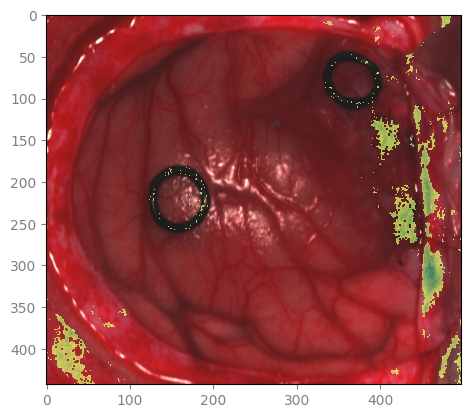

In [18]:
plt.figure()
plt.imshow(img_RGB)
plt.imshow(predicted_mask, cmap=cm.get_cmap('summer'), alpha=0.8)
#plt.figure()
#plt.imshow(img_RGB)
#plt.imshow(predicted_mask_vessel, cmap=cm.get_cmap('Wistia'), alpha=0.4)

(array([[  0.,  53., 116., ...,  33.,  22.,   0.],
        [  0.,  56., 111., ...,  17.,  21.,   0.],
        [  0.,  53., 112., ...,  38.,  15.,   1.],
        ...,
        [  0., 161., 256., ...,   0.,   0.,   0.],
        [  0., 172., 236., ...,   0.,   0.,   0.],
        [  0., 147., 256., ...,   0.,   0.,   0.]]),
 array([-0.03593247, -0.02858884, -0.0212452 , -0.01390157, -0.00655793,
         0.0007857 ,  0.00812933,  0.01547297,  0.0228166 ,  0.03016024,
         0.03750387]),
 <a list of 497 BarContainer objects>)

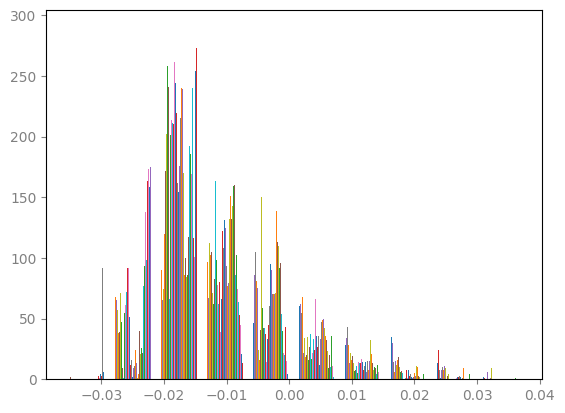

In [219]:
plt.hist(diffCCO_inferred)

/home/kevin/kenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


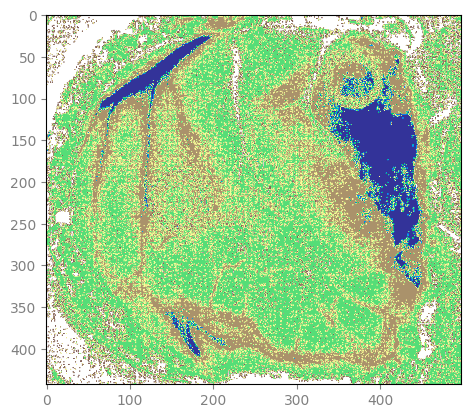

In [228]:
to_estimate = coefs[:]
estimator = sklearn.cluster.KMeans(n_clusters=4)
estimator.fit(to_estimate.reshape(-1,10))
plt.imshow(estimator.predict(to_estimate.reshape(-1,10)).reshape(to_estimate.shape[0], to_estimate.shape[1]))